<a href="https://colab.research.google.com/github/samyzaf/notebooks/blob/main/Poisson1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solving the Poisson Equation with Finite Difference Methods**

* The general form of the two dimensional inhomogeneous
  **Poisson Equation** is:  
  $\qquad
  u_{xx} + u_{yy} = f(x,y),\quad (x,y) \in D
  $

* Boundary conditions:  
  $\qquad u(x,y) = g(x,y), \quad (x,y)\in\partial D
  \text{ (boundary of $D$) }
  $

* First we install and load out **fdmtools** package.


In [1]:
%pip install -q https://samyzaf.com/fdmtools-4.zip
from fdmtools import *

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


# Example
* We will demostarte the Finite Difference Method
  on a simple example  
  $\qquad
  u_{xx} + u_{yy} = 1.25e^{x+\frac{y}{2}}
  $  
  

* With the following Boundary Conditions:  
  $\qquad
  \begin{array}{ll}
  u(x,0) = e^x,     &\quad 0 \leq x \leq 2
  \\
  u(x,2) = e^{x+1}, &\quad 0 \leq x \leq 2
  \\
  u(0,y) = e^{\frac{y}{2}}, &\quad 0 \leq y \leq 2
  \\
  u(2,y) = e^{2+\frac{y}{2}},  &\quad 0 \leq y \leq 2, \text{ right}
  \end{array}
  \newcommand{\Dx}{\Delta x}
  \newcommand{\Dy}{\Delta y}
  \newcommand{\U}{\mathbf{U}}
  \def\a{\alpha}
  \def\b{\beta}
  $  

  <IMG src="https://samyzaf.com/fdm/poisson3a.jpg" width=500 align="center"/>

* The exact solution of this problem is $u(x,y) = e^{x+\frac{y}{2}}$.
* So we can use it to test the accuracy of our numerical solution.

# Finite Difference Grid
* Our domain is a simple square $D=(0,2)\times(0,2)$.
* It is discretised into a uniform mesh $\U$.
* We use the same division size $N$ in the $x$ and $y$
  directions giving a stepsize of $\Dx=\Dy=\frac{2}{N}$.

* Resulting in  
  $\qquad
  \begin{array}{l}
  x_i = i\Dx, \quad  i=0,1,...,N
  \\
  y_j = j\Dx, \quad  j=0,1,...,N
  \end{array}
  $

* Here is a short code snippet for drawing the boundary
  conditions.

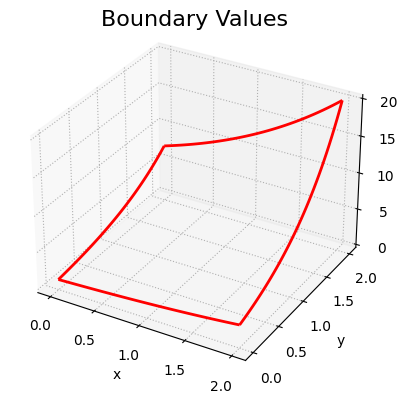

In [2]:
N=40
dx = dy = 2/N                 # Grid steps in x/y axis
U = np.zeros((N+1,N+1))       # Create a new (N+1)x(N+1) grid U with initial zeors

for i in range(N+1):
    U[i,0] = exp(i*dx)        # Bottom boundary condition (x = i*dx)
    U[i,N] = exp(i*dx + 1)    # Top boundary condition

for j in range(N+1):
    U[0,j] = exp(j*dy/2)      # Left boundary condition (y = j*dy)
    U[N,j] = exp(2+j*dy/2)    # Right boundary condition

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
xgrid = np.array([i*dx for i in range(N+1)])
ygrid = np.array([j*dx for j in range(N+1)])
X,Y = np.meshgrid(xgrid, ygrid)
ax.plot_wireframe(X, Y, U, color='red', rcount=1, ccount=1, linewidth=2.0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
plt.title('Boundary Values',fontsize=16, y=1.03)
plt.show()

# Finite Diference Method
* We are ussing the same Grid division size $N=40$ for
  both axis.

* So our grid $\U$ consists of $40\times 40 = 1600$ nodes.

* We will use the central difference second order derivatives  
  $\qquad
  \begin{array}{rcl}
  \U_{xx}[i,j] &=& \displaystyle\frac{\U[i+1,j] -2\U[i,j] + \U[i-1,j]}{\Dx^2}
  \\[2.0ex]
  \U_{yy}[i,j] &=& \displaystyle\frac{\U[i,j+1] -2\U[i,j] + \U[i,j-1]}{\Dx^2}
  \end{array}
  $

* Therefore  
  $\qquad
  \begin{array}{rcl}
  \U_{xx}[i,j] + \U_{yy}[i,j]
  &=&\displaystyle
  \frac{\U[i+1,j] -2\U[i,j] + \U[i-1,j]}{\Dx^2}
  +
  \frac{\U[i,j+1] -2\U[i,j] + \U[i,j-1]}{\Dx^2}
  \\[2.0ex]
  &=&
  \frac{1}{\Dx^2}\,\bigl(
  \U[i-1,j] + \U[i+1,j] + \U[i,j-1] + \U[i,j+1] - 4\U[i,j]
  \bigr)
  \\[2.0ex]
  &=&
  1.25 e^{i\Dx + \frac{j\Dy}{2}}
  \end{array}
  $

* So we get the following difference equation  
  $\qquad
  \U[i-1,j] + \U[i+1,j] + \U[i,j-1] + \U[i,j+1] - 4\U[i,j]
  =
  1.25 \Dx^2 e^{i\Dx + \frac{j\Dy}{2}}
  $

* This is a linear equation with 5 unknowns
  and 5 coefficients $(1,1,1,1,-4)$.

* This equation holds only for **internal nodes** $(i,j)$,
   that is $0 < i,j < N$.

* The **boundary nodes** ($i=0,N$ or $j=0,N$) are
  handled by the given boundary conditions.

* We will build a linear system of $(N+1)^2$ equations
  in $(N+1)^2$ unknowns (all values $\U[i,j]$).

* To make it simple, we will throw into this system all
  the boundary values as if they are linear equtions.  
  $\qquad
  \begin{array}{rclr}
  \U[i,0] &=& e^{i\Dx},      & 0\leq i\leq N
  \\
  \U[i,N] &=& e^{1+i\Dx},    & 0\leq i\leq N
  \\
  \U[0,j] &=& e^{\frac{j\Dy}{2}},   & 0\leq j\leq N
  \\
  \U[N,j] &=& e^{2 + \frac{j\Dy}{2}},   & 0\leq j\leq N
  \end{array}
  $

* This gives us a total of $4N+2$ equations.
  The remaining equations will be obtained from the
  main difference equation above.

* For that purpose we need to convert our $\U[i,j]$
  unknowns to a convetional sequence of variables
  $X_n$, for $n=0,1,2,\ldots,(N+1)^2-1$.

* This is easily achieved by using the bijection
  $\alpha(i,j) = i(N+1)+j$, and defining
  $X_n = \U[i,j]$, where $n=\alpha(i,j)$.

* For example if $N=4$, then this bijection looks like this  
  <IMG src="https://samyzaf.com/fdm/poisson1a.jpg" width=500 align="center"/>

* The inverse function for decoding $(i,j)$ from $n$ is:  
  $\qquad
  \begin{array}{l}
  \beta(n) = \bigl(n//(N+1), \; n\%(N+1) \bigr)
  \\
  \beta\colon  [0:(N+1)^2-1] \to [0:N+1]\times[0:N+1]
  \end{array}
  $  
  where $n//k$ is **integer division** and $n\%k$ is
  the integer remainder of dividing $n$ by $k$.  

* So the bijection from the 2D array variable $\U[i,j]$ and $X_n$
  looks like this:  
  $\qquad
  \U[i,j] \;\longmapsto\; X_{\alpha(i,j)},\qquad
  X_n \longmapsto \U[\beta(n)]
  $

* For example, if $N=3$, then it can be presented as in
  the following table  
  <IMG src="https://samyzaf.com/fdm/poisson2a.jpg" width=500 align="center"/>

* Our main difference equation is translated to a linear equation  
  $\qquad
  X_{\a(i-1,j)} + X_{\a(i+1,j)} + X_{\a(i,j-1)} + X_{\a(i,j+1)} - 4X_{\a(i,j)}
  =
  1.25 \Dx^2 e^{i\Dx + \frac{j\Dy}{2}}
  $  
  There are $(N+1)^2 - (4N+2)$ internal nodes,
  we get same number of linear equtions.

* The $4N+2$ linear equations that correspond to the boundary
  conditions are  
  $\qquad
  \begin{array}{rclr}
   X_{\a(i,0)} &=& e^{i\Dx},      & 0\leq i\leq N
   \\
   X_{\a(i,N)} &=& e^{1+i\Dx},    & 0\leq i\leq N
   \\
   X_{\a(0,j)} &=& e^{\frac{j\Dy}{2}},   & 0\leq j\leq N
   \\
   X_{\a(N,j)} &=& e^{2+\frac{j\Dy}{2}},   & 0\leq j\leq N
   \end{array}
  $

* Or in equivalent form  
  $\qquad
  \begin{array}{rclr}
  X_{i(N+1)} &=& e^{i\Dx},      & 0\leq i\leq N
  \\
  X_{i(N+1)+N} &=& e^{1+i\Dx},    & 0\leq i\leq N
  \\
  X_{j} &=& e^{\frac{j\Dy}{2}},   & 0\leq j\leq N
  \\
  X_{N(N+1)+j} &=& e^{2+\frac{j\Dy}{2}},   & 0\leq j\leq N
  \end{array}
  $

# Our Linear System of Equations
* Lets now summarize the list of equations we have in our system.

* We have $(N+1)^2$ linear equations with $(N+1)^2$ unknowns
  $X_n$, $n=0,1,2,\ldots, (N+1)^2 - 1$.

* To every node $(i,j)$ in our grid $\U$, corresponds one
  linear equation $\mathrm{Eq}[i,j]$
  as specified below.

* For every $i < N+1$ we have two equations  
  $\qquad
  \begin{array}{lll}
  \mathrm{Eq}[i,0]:  &\quad X_{i(N+1)} = e^{i\Dx},      & 0\leq i\leq N+1
  \\
  \mathrm{Eq}[i,N]:  &\quad X_{i(N+1)+N} = e^{1+i\Dx},    & 0\leq i\leq N+1
  \end{array}
  $  
  These are the bottom and top boundary conditions.

* For every $j < N+1$ we have two equations  
  $\qquad
  \begin{array}{lll}
  \mathrm{Eq}[0,j]:
      &\quad X_{j} = e^{\frac{j\Dy}{2}},   & 0\leq j\leq N
  \\
\mathrm{Eq}[N,j]:
      &\quad X_{N(N+1)+j} = e^{2+\frac{j\Dy}{2}},   & 0\leq j\leq N
  \end{array}
  $  
  These are the left and right boundary conditions.

* For any other **internal node** $(i,j)$, we have  
  $\qquad
  \mathrm{Eq}[i,j]:\quad
X_{\a(i-1,j)} + X_{\a(i+1,j)} + X_{\a(i,j-1)} + X_{\a(i,j+1)} - 4X_{\a(i,j)}
  =
  1.25 \Dx^2 e^{i\Dx + \frac{j\Dy}{2}}
  $

* The coefficients matrix of our system $AX=B$
  has the following form.
  We will define row $m$ to be the list of coefficints
  of $\mathrm{Eq}[i,j]$, where $(i,j) = \b(m)$.

* For internal nodes $(i,j)$  
  $\qquad
  \begin{array}{l}
   A[m,\a(i-1,j)] = A[m,\a(i+1,j)] = A[m,\a(i,j-1)] = A[m,\a(i,j+1)] = 1
  \\
  A[m,\a(i,j)] = A[m,m] = - 4
  \end{array}
  $  
  For any other integer $n<(N+1)^2$, $A[m,n]=0$.

* The resulting matrix has the form  
  $\qquad
  A =
  \left(
  \begin{array}{ccccccc}
  T&I&0&0&0&.&.\\
  I&T&I&0&0&.&.\\
  0&I&T&I&0&.&.\\
  0&0&I&T&I&0&.\\
  .&.&.&.&.&.&.\\
  0&.&.&0&I&T&I\\
  0&.&.&.&0&I&T\\
  \end{array}
  \right)
  $

* Where $I$ is the $(N+1)\times(N+1)$ identity matrix,
  and $T$ is an $(N+1)\times(N+1)$ matrix of the form  
  $\qquad
  T = \left(
  \begin{array}{ccccccc}
  -4&1&0&0&.&.&.\\
   1&-4&1&0&0&.&.\\
   0& 1&-4&1&0&0&.\\
   0& 0& 1&-4&1&0&.\\
   .&.&.&.&.&.&.\\
   .&.&.&0&1&-4&1\\
   .&.&.&.&0&1&-4\\
  \end{array}
  \right)
  $

* Finally we need to describe the system vector $B$.  
  For every $m<(N+1)^2$, let $(i,j) = \b(m)$.
  Then  
    
  $\qquad
  B[m] =
  \left\{
  \begin{array}{ll}
  e^{i\Dx}, &\quad j=0
  \\
  e^{1+i\Dx}, &\quad j=N
  \\
  e^{\frac{j\Dy}{2}}, &\quad i=0
  \\
  e^{2 + \frac{j\Dy}{2}}, &\quad i=N
  \\
  1.25 \Dx^2 e^{i\Dx + \frac{j\Dy}{2}}, &\text{otherwise}
  \end{array} \right.
  $

* It can be proven that $A$ is ivertible.
  See https://www.ljll.fr/~frey/cours/UdC/ma691/ma691_ch6.pdf
  for example.

* Therefore our linear system has exactly one solution
  which we can compute with Python Numpy tools.

In [3]:
alpha  = lambda i,j: i*(N+1) + j        # 2D -> 1D map  (encoder)
beta  = lambda n: (n//(N+1), n%(N+1))   # 1D -> 2D map  (decoder)
u = lambda x,y: exp(x + y/2)            # The exact solution of this equation

# A = coefficients matrix of order (n+1)^2 x (n+1)^2
A = np.zeros(((N+1)**2, (N+1)**2))

# Right side coefficients vector
B = np.zeros((N+1)**2)

# A = coefficients matrix from row 0 to row (n+1)^2 - 1
for i in range(N+1):
    for j in range(N+1):
        m = alpha(i,j)
        if i==0 or i==N or j==0 or j==N:
            A[m,m] = 1
        else:
            A[m, alpha(i-1,j)] = 1
            A[m, alpha(i+1,j)] = 1
            A[m, alpha(i,j-1)] = 1
            A[m, alpha(i,j+1)] = 1
            A[m,m] = -4

# Setting the free coefficients vector B
for m in range((N+1)**2):
    i,j = beta(m)
    if j==0:
        B[m] = exp(i*dx)       # Boundary condition bottom
    elif j==N:
        B[m] = exp(1+i*dx)     # Boundary condition top
    elif i==0:
        B[m] = exp(j*dy/2)     # Boundary condition left
    elif i==N:
        B[m] = exp(2+j*dy/2)   # Boundary condition right
    else:
        B[m] = 1.25 * dx**2 * exp(i*dx + j*dy/2)

# Solve the linear system: AX = B   (in one line!)
X = np.linalg.solve(A, B)

# Decode values from X to U
for m in range((N+1)**2):
    i,j = beta(m)
    U[i,j] = X[m]

* Lets verify sample value of real u(x,y) against approximated value.
* The exact solution of our Poisson equation
  is $u(x,y) = e^{x + \frac{y}{2}$.
* So we can check if our algorithm works.

In [4]:
i = N//2
j = N//2
x = i * dx
y = j * dy
print(f"x={x}, y={y}, ; i={i}, j={j}")
print(f"u(x,y)={u(x,y)}")
print(f"U(i,j)={U[i,j]}")
print(f"Error = |u(x,y) - U[i,j]| = {abs(u(x,y) - U[i,j])}")

x=1.0, y=1.0, ; i=20, j=20
u(x,y)=4.4816890703380645
U(i,j)=4.482010163072849
Error = |u(x,y) - U[i,j]| = 0.00032109273478475586


* However, it will be safer if we calculate the maximal error over
  all the nodes of $\U$!
* This can be easily done with **Numpy**.

In [5]:
# First we gather all the eaxct values of u(x,y) over our grid nodes
Ureal = np.array([[u(i*dx, j*dy) for j in range(N+1)] for i in range(N+1)])
E = np.abs(U-Ureal)
max_error = E.max()
print(f"Max error = {max_error}")

Max error = 0.000351109985962772


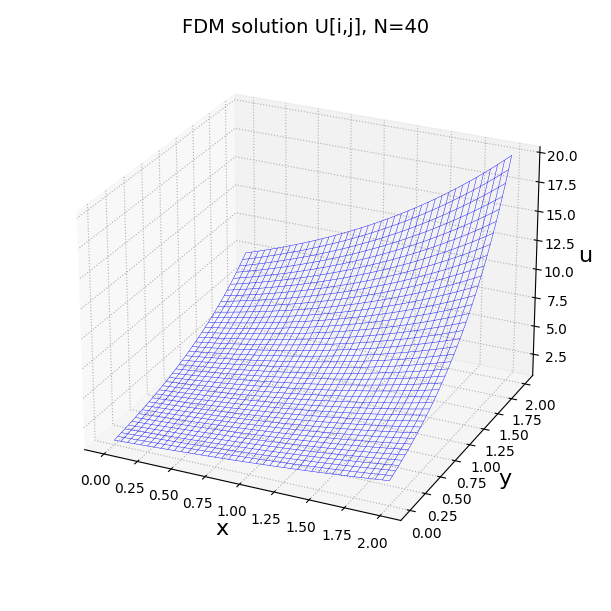

In [6]:
xgrid = [i*dx for i in range(N+1)]
ygrid = [j*dx for j in range(N+1)]
X,Y = np.meshgrid(xgrid, ygrid)
fig = plt.figure(figsize=(7,6), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect(aspect=None, zoom=0.9)
# Plot a basic wireframe.
ax.plot_wireframe(X, Y, U, color='blue', linewidth=0.3)
ax.set_xlabel("x", fontsize=16, fontweight="normal")
ax.set_ylabel("y", fontsize=16, fontweight="normal")
ax.set_zlabel("u", fontsize=16, fontweight="normal")
plt.title(f'FDM solution U[i,j], N={N}',fontsize=14, y=1.03)
ax.view_init(elev=25, azim=-65, roll=0)

* Now we draw the exact solution of our equatio:
  $u(x,y) = e^{x+\frac{y}{2}$.

* We have already defined a grid version of it in **Ureal** above.

* Judging from the 3D graphs, the two surfaces look pretty close!

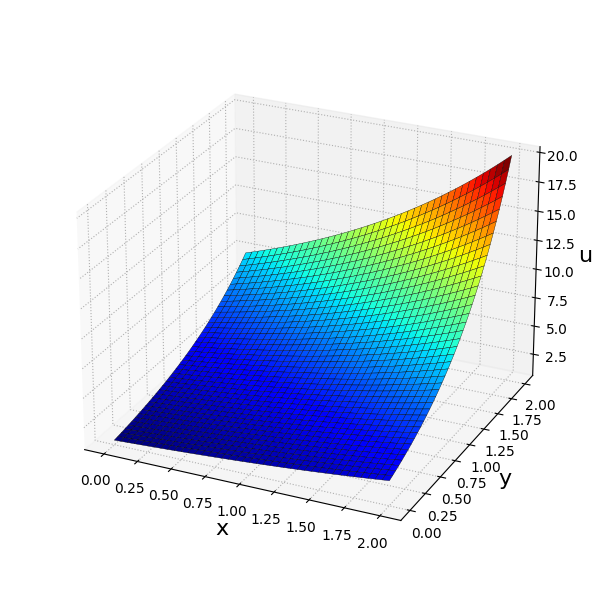

In [7]:
#plt.clf()
fig = plt.figure(figsize=(7,6), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect(aspect=None, zoom=0.9)
xgrid = [i*dx for i in range(N+1)]
ygrid = [j*dx for j in range(N+1)]
X,Y =  np.meshgrid(xgrid, ygrid)
surf = ax.plot_surface(X, Y, Ureal, cmap="jet", linewidth=0.25, edgecolors='black')
ax.set_xlabel("x", fontsize=16, fontweight="normal")
ax.set_ylabel("y", fontsize=16, fontweight="normal")
ax.set_zlabel("u", fontsize=16, fontweight="normal")
ax.view_init(elev=25, azim=-65, roll=0)

